# Defining the functions for model, dataset loading funcitons, training, deploying to an endpoint 
## 1. Defining pipeline, creating yaml files for running the pipelines
## 2. Running the pipelines

In [18]:
USER_FLAG = "--user"

In [2]:
!pip3 install {USER_FLAG} google-cloud-aiplatform==1.7.0
!pip3 install {USER_FLAG} kfp==1.8.9


     |████████████████████████████████| 1.6 MB 9.0 MB/s            
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
     |████████████████████████████████| 296 kB 7.3 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 636 kB 40.9 MB/s            
     |████████████████████████████████| 1.6 MB 54.8 MB/s            
     |████████████████████████████████| 61 kB 24 kB/s              
     |████████████████████████████████| 152 kB 50.5 MB/s            
     |████████████████████████████████| 54 kB 3.0 MB/s             
     |████████████████████████████████| 52 kB 1.6 MB/s             
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 56 kB 4.6 MB/s             
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     |█████

In [1]:
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)


In [1]:
!python3 -c "import kfp; print('KFP SDK version: {}'.format(kfp.__version__))"

KFP SDK version: 1.8.9


In [2]:
!pip list | grep aiplatform

google-cloud-aiplatform               1.7.0


In [3]:
import os
PROJECT_ID = ""

# Get your Google Cloud project ID from gcloud
if not os.getenv("IS_TESTING"):
    shell_output=!gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID: ", PROJECT_ID)


Project ID:  assignments-334518


In [4]:
BUCKET_NAME="gs://" + PROJECT_ID + "-bucket"


In [5]:
import matplotlib.pyplot as plt
import pandas as pd

from kfp.v2 import compiler, dsl
from kfp.v2.dsl import pipeline, component, Artifact, Dataset, Input, Metrics, Model, Output, InputPath, OutputPath

from google.cloud import aiplatform

# We'll use this namespace for metadata querying
from google.cloud import aiplatform_v1

In [6]:
PATH=%env PATH
%env PATH={PATH}:/home/jupyter/.local/bin
REGION="us-central1"

PIPELINE_ROOT = f"{BUCKET_NAME}/pipeline_root/"
PIPELINE_ROOT

env: PATH=/usr/local/cuda/bin:/opt/conda/bin:/opt/conda/condabin:/usr/local/bin:/usr/bin:/bin:/usr/local/games:/usr/games:/home/jupyter/.local/bin


'gs://assignments-334518-bucket/pipeline_root/'

In [7]:
#Download data from big query and change to csv

@component(
    packages_to_install=["google-cloud-bigquery", "pandas", "pyarrow"],
    base_image="python:3.9",
    output_component_file="create_dataset.yaml"
)
def get_dataframe(
    bq_table: str,
    output_data_path: OutputPath("Dataset")
):
    from google.cloud import bigquery
    import pandas as pd

    bqclient = bigquery.Client()
    table = bigquery.TableReference.from_string(
        bq_table
    )
    rows = bqclient.list_rows(
        table
    )
    dataframe = rows.to_dataframe(
        create_bqstorage_client=True,
    )
    dataframe = dataframe.sample(frac=1, random_state=2)
    dataframe.to_csv(output_data_path)

In [8]:
# take the created csv in the last step to train a scikit-learn decision tree model

@component(
    packages_to_install=["sklearn", "pandas", "joblib"],
    base_image="python:3.9",
    output_component_file="beans_model_component.yaml",
)
def sklearn_train(
    dataset: Input[Dataset],
    metrics: Output[Metrics],
    model: Output[Model]
):
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.metrics import roc_curve
    from sklearn.model_selection import train_test_split
    from joblib import dump

    import pandas as pd
    df = pd.read_csv(dataset.path)
    labels = df.pop("Class").tolist()
    data = df.values.tolist()
    x_train, x_test, y_train, y_test = train_test_split(data, labels)

    skmodel = DecisionTreeClassifier()
    skmodel.fit(x_train,y_train)
    score = skmodel.score(x_test,y_test)
    print('accuracy is:',score)

    metrics.log_metric("accuracy",(score * 100.0))
    metrics.log_metric("framework", "Scikit Learn")
    metrics.log_metric("dataset_size", len(df))
    dump(skmodel, model.path + ".joblib")

In [9]:
# take trained model from the previous step, upload it to Vertex AI, and deploy it to an endpoint

@component(
    packages_to_install=["google-cloud-aiplatform"],
    base_image="python:3.9",
    output_component_file="beans_deploy_component.yaml",
)
def deploy_model(
    model: Input[Model],
    project: str,
    region: str,
    vertex_endpoint: Output[Artifact],
    vertex_model: Output[Model]
):
    from google.cloud import aiplatform

    aiplatform.init(project=project, location=region)

    deployed_model = aiplatform.Model.upload(
        display_name="beans-model-pipeline",
        artifact_uri = model.uri.replace("model", ""),
        serving_container_image_uri="us-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.0-24:latest"
    )
    endpoint = deployed_model.deploy(machine_type="n1-standard-4")

    # Save data to the output params
    vertex_endpoint.uri = endpoint.resource_name
    vertex_model.uri = deployed_model.resource_name

In [10]:
#creating the pipeline definition for running the steps

@pipeline(
    # Default pipeline root. You can override it when submitting the pipeline.
    pipeline_root=PIPELINE_ROOT,
    # A name for the pipeline.
    name="mlmd-pipeline",
)
def pipeline(
    bq_table: str = "",
    output_data_path: str = "data.csv",
    project: str = PROJECT_ID,
    region: str = REGION
):
    dataset_task = get_dataframe(bq_table)

    model_task = sklearn_train(
        dataset_task.output
    )

    deploy_task = deploy_model(
        model=model_task.outputs["model"],
        project=project,
        region=region
    )

In [11]:
#generate a json file to run the pipeline

compiler.Compiler().compile(
    pipeline_func=pipeline, package_path="mlmd_pipeline.json"
)

/home/jupyter/.local/lib/python3.7/site-packages/kfp/v2/compiler/compiler.py:1266: FutureWarning: APIs imported from the v1 namespace (e.g. kfp.dsl, kfp.components, etc) will not be supported by the v2 compiler since v2.0.0
  category=FutureWarning,


# Starting pipeline runs

In [12]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

In [14]:
#runs a pipeline with the smaller version of the beans dataset 

run1 = aiplatform.PipelineJob(
    display_name="mlmd-pipeline",
    template_path="mlmd_pipeline.json",
    job_id="mlmd-pipeline-small-{0}".format(TIMESTAMP),
    parameter_values={"bq_table": "sara-vertex-demos.beans_demo.small_dataset"},
    enable_caching=True,
)

In [15]:
#runs a pipeline with a large version of the beans dataset

run2 = aiplatform.PipelineJob(
    display_name="mlmd-pipeline",
    template_path="mlmd_pipeline.json",
    job_id="mlmd-pipeline-large-{0}".format(TIMESTAMP),
    parameter_values={"bq_table": "sara-vertex-demos.beans_demo.large_dataset"},
    enable_caching=True,
)

## Running the pipelines

In [16]:
run1.submit()


INFO:google.cloud.aiplatform.pipeline_jobs:Creating PipelineJob
INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob created. Resource name: projects/438895751747/locations/us-central1/pipelineJobs/mlmd-pipeline-small-20211208225825
INFO:google.cloud.aiplatform.pipeline_jobs:To use this PipelineJob in another session:
INFO:google.cloud.aiplatform.pipeline_jobs:pipeline_job = aiplatform.PipelineJob.get('projects/438895751747/locations/us-central1/pipelineJobs/mlmd-pipeline-small-20211208225825')
INFO:google.cloud.aiplatform.pipeline_jobs:View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/mlmd-pipeline-small-20211208225825?project=438895751747


In [17]:
run2.submit()

INFO:google.cloud.aiplatform.pipeline_jobs:Creating PipelineJob
INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob created. Resource name: projects/438895751747/locations/us-central1/pipelineJobs/mlmd-pipeline-large-20211208225825
INFO:google.cloud.aiplatform.pipeline_jobs:To use this PipelineJob in another session:
INFO:google.cloud.aiplatform.pipeline_jobs:pipeline_job = aiplatform.PipelineJob.get('projects/438895751747/locations/us-central1/pipelineJobs/mlmd-pipeline-large-20211208225825')
INFO:google.cloud.aiplatform.pipeline_jobs:View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/mlmd-pipeline-large-20211208225825?project=438895751747


### Comparing the pipelines using Vertex SDK

In [19]:
df = aiplatform.get_pipeline_df(pipeline="mlmd-pipeline")
df

,pipeline_name,run_name,param.input:project,param.input:region,param.input:bq_table,param.input:output_data_path,metric.framework,metric.accuracy,metric.dataset_size
0,mlmd-pipeline,mlmd-pipeline-large-20211208225825,assignments-334518,us-central1,sara-vertex-demos.beans_demo.large_dataset,data.csv,Scikit Learn,99.941228,13611.0
1,mlmd-pipeline,mlmd-pipeline-small-20211208225825,assignments-334518,us-central1,sara-vertex-demos.beans_demo.small_dataset,data.csv,Scikit Learn,100.000000,700.0


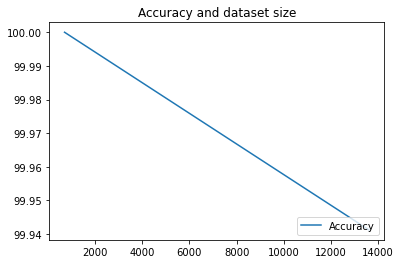

In [20]:
plt.plot(df["metric.dataset_size"], df["metric.accuracy"],label="Accuracy")
plt.title("Accuracy and dataset size")
plt.legend(loc=4)
plt.show()

## Querying model artifacts

In [22]:
API_ENDPOINT = "{}-aiplatform.googleapis.com".format(REGION)
metadata_client = aiplatform_v1.MetadataServiceClient(
  client_options={
      "api_endpoint": API_ENDPOINT
  }
)


In [23]:
MODEL_FILTER="schema_title = \"system.Model\""
artifact_request = aiplatform_v1.ListArtifactsRequest(
    parent="projects/{0}/locations/{1}/metadataStores/default".format(PROJECT_ID, REGION),
    filter=MODEL_FILTER
)
model_artifacts = metadata_client.list_artifacts(artifact_request)


In [24]:
LIVE_FILTER = "create_time > \"2021-08-10T00:00:00-00:00\" AND state = LIVE"
artifact_req = {
    "parent": "projects/{0}/locations/{1}/metadataStores/default".format(PROJECT_ID, REGION),
    "filter": LIVE_FILTER
}
live_artifacts = metadata_client.list_artifacts(artifact_req)


In [25]:
data = {'uri': [], 'createTime': [], 'type': []}

for i in live_artifacts:
    data['uri'].append(i.uri)
    data['createTime'].append(i.create_time)
    data['type'].append(i.schema_title)

df = pd.DataFrame.from_dict(data)
df

,uri,createTime,type
0,gs://assignments-334518-bucket/pipeline_root/4...,2021-12-08 23:03:30.347000+00:00,system.Metrics
1,projects/438895751747/locations/us-central1/mo...,2021-12-08 23:06:45.449000+00:00,system.Model
2,projects/438895751747/locations/us-central1/en...,2021-12-08 23:06:45.548000+00:00,system.Artifact
3,projects/438895751747/locations/us-central1/en...,2021-12-08 23:06:54.656000+00:00,system.Artifact
4,projects/438895751747/locations/us-central1/mo...,2021-12-08 23:06:54.570000+00:00,system.Model
5,gs://assignments-334518-bucket/pipeline_root/4...,2021-12-08 23:03:19.213000+00:00,system.Metrics
6,gs://assignments-334518-bucket/pipeline_root/4...,2021-12-08 23:03:19.102000+00:00,system.Model
7,gs://assignments-334518-bucket/pipeline_root/4...,2021-12-08 23:03:30.448000+00:00,system.Model
8,gs://assignments-334518-bucket/pipeline_root/4...,2021-12-08 23:00:25.583000+00:00,system.Dataset
9,gs://assignments-334518-bucket/pipeline_root/4...,2021-12-08 23:00:03.992000+00:00,system.Dataset
